In [1]:
import os
import sys
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

home_path = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
data_path = os.path.join(home_path, "data")
input_path = os.path.join(home_path, "input")
output_path = os.path.join(home_path, "output")
model_path = os.path.join(output_path, "model")

def load_data():
    '''load the MovieLens 1m dataset in a Pandas dataframe'''
    ratings = pd.read_csv(os.path.join(data_path,'ml-1m/ratings.dat'), delimiter='::', header=None, 
        names=['user_id', 'movie_id', 'rating', 'timestamp'], 
        usecols=['user_id', 'movie_id', 'rating'], engine='python')
    
    movies = pd.read_csv(os.path.join(data_path,'ml-1m/movies.dat'), engine='python', header=None,
                         sep='::', names=['movie_id', 'title', 'genre'], encoding_errors="ignore")

    users = pd.read_csv(os.path.join(data_path, 'ml-1m/users.dat'), delimiter='::', header=None, 
        names=['user_id', 'gender', 'age', 'occupation'], 
        usecols=['user_id', 'gender', 'age', 'occupation'], engine='python')
    
    return ratings, movies, users

In [2]:
ratings, movies, users = load_data()

In [3]:
users

,user_id,gender,age,occupation
0,1,F,1,10
1,2,M,56,16
2,3,M,25,15
3,4,M,45,7
4,5,M,25,20
...,...,...,...,...
6035,6036,F,25,15
6036,6037,F,45,1
6037,6038,F,56,1
6038,6039,F,45,0


In [4]:
movies.movie_id.max()

3952

In [5]:
ratings.movie_id.nunique()

3706

In [6]:
data = ratings.merge(users, on="user_id", how="inner")

In [7]:
data = data[["user_id", "movie_id","gender", "age", "occupation", "rating"]].copy()

In [8]:
data["user_id"] = data["user_id"] - 1
data["movie_id"] = data["movie_id"] - 1
data["gender"] = data["gender"].apply(lambda x: 0 if x=="F" else 1)

dict_age = {1: 0, 18: 1, 25: 2, 35: 4, 45: 5, 50:5, 56:6}
data["age"] = data["age"].apply(lambda x: dict_age[x])

data["occupation"] = data["occupation"]

In [9]:
dict_col_offset = {"user_id":0,
                  "movie_id":users.user_id.max(),
                  "gender":users.user_id.max()+movies.movie_id.max(),
                  "age":users.user_id.max()+movies.movie_id.max()+2,
                  "occupation":users.user_id.max()+movies.movie_id.max()+2+(len(dict_age))}

In [10]:
dict_col_offset

{'user_id': 0,
 'movie_id': 6040,
 'gender': 9992,
 'age': 9994,
 'occupation': 10001}

In [11]:
for col in data.columns[:-1]:
    data[col] = data[col] + dict_col_offset[col]

In [12]:
data

,user_id,movie_id,gender,age,occupation,rating
0,0,7232,9992,9994,10011,5
1,0,6700,9992,9994,10011,3
2,0,6953,9992,9994,10011,3
3,0,9447,9992,9994,10011,4
4,0,8394,9992,9994,10011,5
...,...,...,...,...,...,...
1000204,6039,7130,9993,9996,10007,1
1000205,6039,7133,9993,9996,10007,5
1000206,6039,6601,9993,9996,10007,5
1000207,6039,7135,9993,9996,10007,4


In [13]:
for col in data.columns:
    print(data[col].min(), data[col].max())

0 6039
6040 9991
9992 9993
9994 10000
10001 10021
1 5


In [14]:
num_feats = dict_col_offset["occupation"] + 20
num_feats

10021

In [15]:
from torch.utils.data import Dataset

class FMDataset(Dataset):
    def __init__(self, X, y):
        super(FMDataset, self).__init__()
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
        
    def __getitem__(self, index):
        X = torch.tensor(self.X[index], dtype=torch.long)
        y = torch.tensor(self.y[index], dtype=torch.float)
        
        return X, y

In [16]:
X = data.loc[:, data.columns[:-1]]
y = data.iloc[:, -1]

fmDataset = FMDataset(X.values, y.values)

In [17]:
train_ratio = 0.8
train_size = int(len(fmDataset) * train_ratio)
test_size = len(fmDataset) - train_size

random_seed = 100

train_dataset, test_dataset = torch.utils.data.random_split(fmDataset, [train_size, test_size], generator=torch.Generator().manual_seed(random_seed))

In [18]:
class FM(nn.Module):
    def __init__(self, num_feats, emb_dim):
        super(FM, self).__init__()
        self.embedding = nn.Embedding(num_feats, emb_dim)
        self.weight = nn.Parameter(torch.zeros(num_feats))
        self.offset = nn.Parameter(torch.zeros(1))
        
        torch.nn.init.xavier_uniform_(self.embedding.weight)
#         torch.nn.init.uniform_(self.embedding.weight)
        
    def forward(self, X):
        emb = self.embedding(X)
        square_of_sum = torch.sum(emb, dim=1) ** 2
        sum_of_square = torch.sum(emb ** 2, dim = 1)
        interaction = (square_of_sum - sum_of_square).sum(dim=1) * 0.5
        
        linear = torch.sum(self.weight[X], dim=1)
    
        X_out = self.offset + linear + interaction
    
        X_out = self.sigmoid_range(X_out)
    
        return X_out
    
    # to return 
    def sigmoid_range(self, x, low=1, high=5):
        return torch.sigmoid(x) * (high-low) + low

In [19]:
bs = 1024
lr = 0.001
epochs = 100

USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else "cpu")
device

device(type='cuda', index=0)

In [20]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, bs, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, bs, shuffle=False)

In [21]:
fm = FM(data[dict_col_offset.keys()].values.max()+1, emb_dim=10)
fm.to(device)
opt = optim.AdamW(fm.parameters(), lr=lr, weight_decay=0.01)
loss_fn = nn.MSELoss()

In [22]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max"):

        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):

        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score: #  + self.delta
            self.counter += 1
            # print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            # ema.apply_shadow()
            self.save_checkpoint(epoch_score, model, model_path)
            # ema.restore()
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(f"Validation score improved ({self.val_score:.4f} --> {epoch_score:.4f}). Saving model!")
            # if not DEBUG:
#             self.data_loader.save_model(model.state_dict(),model_path)
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [95]:
from tqdm.notebook import tqdm

epoch_train_losses = []
epoch_test_losses = []

patience = 7

if patience > 0:
    es = EarlyStopping(patience, "min")

for epoch in tqdm(range(epochs)):
    train_losses, test_losses = [], []
    fm.train()
    for inputs in train_dataloader:
        train_X, train_y = inputs
        
        train_X = train_X.to(device)
        train_y = train_y.to(device)
        
        preds = fm(train_X)
        loss = loss_fn(preds, train_y)
        train_losses.append(loss.item())
        
        opt.zero_grad() # or model.zero_grad() - when model uses multiple optimizers
        loss.backward()
        opt.step()
        
    fm.eval()
    with torch.no_grad():
        for inputs in test_dataloader:
            test_X, test_y = inputs
        
            test_X = test_X.to(device)
            test_y = test_y.to(device)

            preds = fm(test_X)
            loss = loss_fn(preds, test_y)
            test_losses.append(loss.item())
            
    epoch_train_loss = np.mean(train_losses)
    epoch_test_loss = np.mean(test_losses)
    epoch_train_losses.append(epoch_train_loss)
    epoch_test_losses.append(epoch_test_loss)
    
    s = f'Epoch: {epoch+1}, Train Loss: {epoch_train_loss:0.4f}, Val loss: {epoch_test_loss:0.4f}'
    
    model_weight = os.path.join(model_path, "FM.pth")
    
    print(s)
    
    if patience > 0:
        es(epoch_test_loss, fm, model_weight)
        if es.early_stop:
            print("Early Stopping")
            break
    

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.9518, Val loss: 0.8397
Validation score improved (inf --> 0.8397). Saving model!
Epoch: 2, Train Loss: 0.8231, Val loss: 0.8272
Validation score improved (0.8397 --> 0.8272). Saving model!
Epoch: 3, Train Loss: 0.8152, Val loss: 0.8240
Validation score improved (0.8272 --> 0.8240). Saving model!
Epoch: 4, Train Loss: 0.8113, Val loss: 0.8218
Validation score improved (0.8240 --> 0.8218). Saving model!
Epoch: 5, Train Loss: 0.8062, Val loss: 0.8178
Validation score improved (0.8218 --> 0.8178). Saving model!
Epoch: 6, Train Loss: 0.7999, Val loss: 0.8134
Validation score improved (0.8178 --> 0.8134). Saving model!
Epoch: 7, Train Loss: 0.7932, Val loss: 0.8100
Validation score improved (0.8134 --> 0.8100). Saving model!
Epoch: 8, Train Loss: 0.7872, Val loss: 0.8071
Validation score improved (0.8100 --> 0.8071). Saving model!
Epoch: 9, Train Loss: 0.7813, Val loss: 0.8041
Validation score improved (0.8071 --> 0.8041). Saving model!
Epoch: 10, Train Loss: 0.7753, 

In [23]:
fm = FM(data[dict_col_offset.keys()].values.max()+1, emb_dim=10)
fm.load_state_dict(torch.load(os.path.join(model_path, "FM.pth")))
fm.to(device)

FM(
  (embedding): Embedding(10022, 10)
)

Preds min/max: 1.00 / 5.00
Rating min/max: 1.00 / 5.00


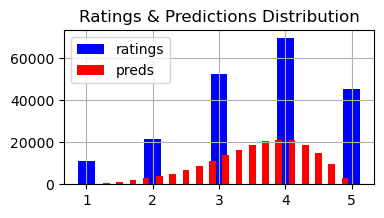

In [24]:
import matplotlib.pyplot as plt

list_preds, list_ratings = [], []
fm.eval()

with torch.no_grad():
    for inputs in test_dataloader:
        X_test, y_test = inputs

        X_test = X_test.to(device)
        y_test = y_test.to(device)
        
        preds = fm(X_test)
        
        list_preds.extend(preds.detach().cpu().numpy().tolist())
        list_ratings.extend(y_test.detach().cpu().numpy().tolist())
        
print(f'Preds min/max: {min(list_preds):0.2f} / {max(list_preds):0.2f}')
print(f'Rating min/max: {min(list_ratings):0.2f} / {max(list_ratings):0.2f}')

plt.figure(figsize=[4,2])
plt.hist(list_ratings, label='ratings', bins=(np.arange(1,7)-0.5),
         rwidth=0.25, color='blue')
plt.hist(list_preds, label='preds', bins=20, rwidth=0.5, color='red')
plt.title('Ratings & Predictions Distribution')
plt.grid()
plt.legend();

In [25]:
movies["movie_id"] = movies["movie_id"] - 1

idxs_movies = torch.tensor(movies['movie_id'].values + dict_col_offset["movie_id"], device=device)
movie_embs = fm.embedding.weight[idxs_movies]
movie_biases = fm.weight[idxs_movies]
movies['emb'] = movie_embs.tolist()
movies['bias'] = movie_biases.tolist()

In [26]:
movies

,movie_id,title,genre,emb,bias
0,0,Toy Story (1995),Animation|Children's|Comedy,"[0.5456219911575317, -0.6667914986610413, -0.5...",0.192742
1,1,Jumanji (1995),Adventure|Children's|Fantasy,"[0.4570470452308655, -0.3089454770088196, -0.2...",-0.148427
2,2,Grumpier Old Men (1995),Comedy|Romance,"[0.15744063258171082, 0.04721004143357277, 0.2...",-0.019953
3,3,Waiting to Exhale (1995),Comedy|Drama,"[-0.03652679920196533, 0.1649157553911209, 0.0...",-0.377280
4,4,Father of the Bride Part II (1995),Comedy,"[0.5313411355018616, 0.31978288292884827, -0.1...",-0.095315
...,...,...,...,...,...
3878,3947,Meet the Parents (2000),Comedy,"[0.6977165341377258, 0.2672056257724762, -0.03...",0.261014
3879,3948,Requiem for a Dream (2000),Drama,"[-0.0681922510266304, -0.5934036374092102, 0.1...",0.081365
3880,3949,Tigerland (2000),Drama,"[-0.19953469932079315, -0.07395531237125397, -...",-0.009428
3881,3950,Two Family House (2000),Drama,"[0.23229548335075378, -0.6334577202796936, 0.1...",0.002395


In [27]:
genre_cols = ['Children\'s', 'Horror', 'Documentary']
GENRES = '|'.join(genre_cols)
print(f'Genres: {GENRES}')

movies_subset = movies[movies['genre'].str.contains(GENRES)].copy()

Genres: Children's|Horror|Documentary


In [28]:
movies_subset

,movie_id,title,genre,emb,bias
0,0,Toy Story (1995),Animation|Children's|Comedy,"[0.5456219911575317, -0.6667914986610413, -0.5...",0.192742
1,1,Jumanji (1995),Adventure|Children's|Fantasy,"[0.4570470452308655, -0.3089454770088196, -0.2...",-0.148427
7,7,Tom and Huck (1995),Adventure|Children's,"[0.18547825515270233, -0.0068274070508778095, ...",-0.145435
11,11,Dracula: Dead and Loving It (1995),Comedy|Horror,"[0.5018914937973022, 0.7244855761528015, -0.04...",-0.264716
12,12,Balto (1995),Animation|Children's,"[-0.016411636024713516, -0.09539053589105606, ...",-0.031613
...,...,...,...,...,...
3869,3938,"Slumber Party Massacre II, The (1987)",Horror,"[0.21240931749343872, 0.6849419474601746, 0.29...",-0.451360
3870,3939,"Slumber Party Massacre III, The (1990)",Horror,"[0.6621560454368591, 1.0845410823822021, 0.851...",-0.758580
3871,3940,Sorority House Massacre (1986),Horror,"[0.6721964478492737, 0.9666470289230347, 0.258...",-0.435176
3872,3941,Sorority House Massacre II (1990),Horror,"[0.23686595261096954, 0.5641666054725647, 0.36...",-0.501947


In [29]:
from sklearn.manifold import TSNE

X = np.stack(movies_subset['emb'].values)
ldr = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=0)
Y = ldr.fit_transform(X)
movies_subset['x'] = Y[:, 0]
movies_subset['y'] = Y[:, 1]


C:\Users\SDMLAB1\anaconda3\envs\recsys\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [30]:
movies_subset

,movie_id,title,genre,emb,bias,x,y
0,0,Toy Story (1995),Animation|Children's|Comedy,"[0.5456219911575317, -0.6667914986610413, -0.5...",0.192742,25.047884,-11.782210
1,1,Jumanji (1995),Adventure|Children's|Fantasy,"[0.4570470452308655, -0.3089454770088196, -0.2...",-0.148427,8.344481,-21.486723
7,7,Tom and Huck (1995),Adventure|Children's,"[0.18547825515270233, -0.0068274070508778095, ...",-0.145435,-0.012268,-12.260075
11,11,Dracula: Dead and Loving It (1995),Comedy|Horror,"[0.5018914937973022, 0.7244855761528015, -0.04...",-0.264716,-21.655767,-11.542581
12,12,Balto (1995),Animation|Children's,"[-0.016411636024713516, -0.09539053589105606, ...",-0.031613,4.450024,-11.480403
...,...,...,...,...,...,...,...
3869,3938,"Slumber Party Massacre II, The (1987)",Horror,"[0.21240931749343872, 0.6849419474601746, 0.29...",-0.451360,-33.887718,7.485508
3870,3939,"Slumber Party Massacre III, The (1990)",Horror,"[0.6621560454368591, 1.0845410823822021, 0.851...",-0.758580,-32.115753,-5.598922
3871,3940,Sorority House Massacre (1986),Horror,"[0.6721964478492737, 0.9666470289230347, 0.258...",-0.435176,-24.010420,-6.678760
3872,3941,Sorority House Massacre II (1990),Horror,"[0.23686595261096954, 0.5641666054725647, 0.36...",-0.501947,-26.769047,7.827927


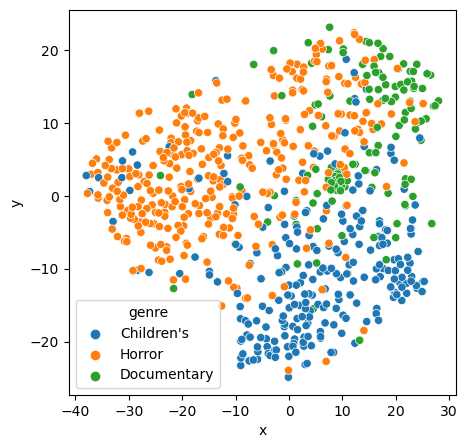

In [31]:
import seaborn as sns

def single_genre(genres):
    """ Filter movies for genre in genre_cols"""
    for genre in genre_cols:
        if genre in genres: return genre

movies_subset['genre'] = movies_subset['genre'].apply(single_genre)
plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x='x', y='y', hue='genre', data=movies_subset)

In [32]:
dict_title_to_mid = dict(zip(movies["title"], movies["movie_id"]))
dict_mid_to_title = {v:k for k,v in dict_title_to_mid.items()}


mid_toy2 = dict_title_to_mid['Toy Story 2 (1999)']
mid_toy2_offset = mid_toy2 + dict_col_offset["movie_id"]
emb_toy2 = fm.embedding(torch.tensor(mid_toy2_offset, dtype=torch.long).to(device)).detach().cpu()
emb_toy2

tensor([ 0.6986, -0.6790, -0.5879, -0.1756,  0.4217,  0.7860, -0.2991,  0.0871,
        -0.4538, -0.2130])

In [33]:
dict_mid_to_title

{0: 'Toy Story (1995)',
 1: 'Jumanji (1995)',
 2: 'Grumpier Old Men (1995)',
 3: 'Waiting to Exhale (1995)',
 4: 'Father of the Bride Part II (1995)',
 5: 'Heat (1995)',
 6: 'Sabrina (1995)',
 7: 'Tom and Huck (1995)',
 8: 'Sudden Death (1995)',
 9: 'GoldenEye (1995)',
 10: 'American President, The (1995)',
 11: 'Dracula: Dead and Loving It (1995)',
 12: 'Balto (1995)',
 13: 'Nixon (1995)',
 14: 'Cutthroat Island (1995)',
 15: 'Casino (1995)',
 16: 'Sense and Sensibility (1995)',
 17: 'Four Rooms (1995)',
 18: 'Ace Ventura: When Nature Calls (1995)',
 19: 'Money Train (1995)',
 20: 'Get Shorty (1995)',
 21: 'Copycat (1995)',
 22: 'Assassins (1995)',
 23: 'Powder (1995)',
 24: 'Leaving Las Vegas (1995)',
 25: 'Othello (1995)',
 26: 'Now and Then (1995)',
 27: 'Persuasion (1995)',
 28: 'City of Lost Children, The (1995)',
 29: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 30: 'Dangerous Minds (1995)',
 31: 'Twelve Monkeys (1995)',
 32: 'Wings of Courage (1995)',
 33: 'Babe (19

In [37]:
# import pickle

# with open(os.path.join(input_path, "dict_mid_to_title.pkl"), "wb") as f:
#     pickle.dump(dict_mid_to_title, f)

In [34]:
dict_mid_to_title

{0: 'Toy Story (1995)',
 1: 'Jumanji (1995)',
 2: 'Grumpier Old Men (1995)',
 3: 'Waiting to Exhale (1995)',
 4: 'Father of the Bride Part II (1995)',
 5: 'Heat (1995)',
 6: 'Sabrina (1995)',
 7: 'Tom and Huck (1995)',
 8: 'Sudden Death (1995)',
 9: 'GoldenEye (1995)',
 10: 'American President, The (1995)',
 11: 'Dracula: Dead and Loving It (1995)',
 12: 'Balto (1995)',
 13: 'Nixon (1995)',
 14: 'Cutthroat Island (1995)',
 15: 'Casino (1995)',
 16: 'Sense and Sensibility (1995)',
 17: 'Four Rooms (1995)',
 18: 'Ace Ventura: When Nature Calls (1995)',
 19: 'Money Train (1995)',
 20: 'Get Shorty (1995)',
 21: 'Copycat (1995)',
 22: 'Assassins (1995)',
 23: 'Powder (1995)',
 24: 'Leaving Las Vegas (1995)',
 25: 'Othello (1995)',
 26: 'Now and Then (1995)',
 27: 'Persuasion (1995)',
 28: 'City of Lost Children, The (1995)',
 29: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 30: 'Dangerous Minds (1995)',
 31: 'Twelve Monkeys (1995)',
 32: 'Wings of Courage (1995)',
 33: 'Babe (19

In [35]:
movie_embs= fm.embedding.weight[dict_col_offset["movie_id"]:dict_col_offset["gender"], :].detach().cpu()
movie_embs

tensor([[ 0.5456, -0.6668, -0.5612,  ...,  0.1284, -0.4157, -0.0115],
        [ 0.4570, -0.3089, -0.2481,  ...,  0.3594,  0.2027,  0.1295],
        [ 0.1574,  0.0472,  0.2754,  ..., -0.5704,  0.3815,  0.2627],
        ...,
        [-0.1995, -0.0740, -0.4075,  ..., -0.2625, -0.0660,  0.0152],
        [ 0.2323, -0.6335,  0.1983,  ...,  0.3334, -0.1034, -0.8370],
        [-0.2604,  0.0341, -0.2556,  ...,  0.0107,  0.1134, -0.0876]])

In [36]:
import torch.nn.functional as F

cos = torch.tensor(
    [F.cosine_similarity(emb_toy2, emb, dim=0) for emb in movie_embs]
)

In [37]:
movie_sims = sorted(cos.detach().numpy(), reverse=True)[:20]
movie_recs = [dict_mid_to_title[idx] for idx in cos.argsort(descending=True)[:20].detach().numpy()]

In [38]:
movies

,movie_id,title,genre,emb,bias
0,0,Toy Story (1995),Animation|Children's|Comedy,"[0.5456219911575317, -0.6667914986610413, -0.5...",0.192742
1,1,Jumanji (1995),Adventure|Children's|Fantasy,"[0.4570470452308655, -0.3089454770088196, -0.2...",-0.148427
2,2,Grumpier Old Men (1995),Comedy|Romance,"[0.15744063258171082, 0.04721004143357277, 0.2...",-0.019953
3,3,Waiting to Exhale (1995),Comedy|Drama,"[-0.03652679920196533, 0.1649157553911209, 0.0...",-0.377280
4,4,Father of the Bride Part II (1995),Comedy,"[0.5313411355018616, 0.31978288292884827, -0.1...",-0.095315
...,...,...,...,...,...
3878,3947,Meet the Parents (2000),Comedy,"[0.6977165341377258, 0.2672056257724762, -0.03...",0.261014
3879,3948,Requiem for a Dream (2000),Drama,"[-0.0681922510266304, -0.5934036374092102, 0.1...",0.081365
3880,3949,Tigerland (2000),Drama,"[-0.19953469932079315, -0.07395531237125397, -...",-0.009428
3881,3950,Two Family House (2000),Drama,"[0.23229548335075378, -0.6334577202796936, 0.1...",0.002395


In [42]:
idx_movie_rec = [idx for idx in cos.argsort(descending=True)[:20].detach().numpy()]

In [45]:
movies.loc[movies.title == 'Toy Story 2 (1999)']

,movie_id,title,genre,emb,bias
3045,3113,Toy Story 2 (1999),Animation|Children's|Comedy,"[0.698576807975769, -0.6789625287055969, -0.58...",0.165498


In [46]:
movies

,movie_id,title,genre,emb,bias
0,0,Toy Story (1995),Animation|Children's|Comedy,"[0.5456219911575317, -0.6667914986610413, -0.5...",0.192742
1,1,Jumanji (1995),Adventure|Children's|Fantasy,"[0.4570470452308655, -0.3089454770088196, -0.2...",-0.148427
2,2,Grumpier Old Men (1995),Comedy|Romance,"[0.15744063258171082, 0.04721004143357277, 0.2...",-0.019953
3,3,Waiting to Exhale (1995),Comedy|Drama,"[-0.03652679920196533, 0.1649157553911209, 0.0...",-0.377280
4,4,Father of the Bride Part II (1995),Comedy,"[0.5313411355018616, 0.31978288292884827, -0.1...",-0.095315
...,...,...,...,...,...
3878,3947,Meet the Parents (2000),Comedy,"[0.6977165341377258, 0.2672056257724762, -0.03...",0.261014
3879,3948,Requiem for a Dream (2000),Drama,"[-0.0681922510266304, -0.5934036374092102, 0.1...",0.081365
3880,3949,Tigerland (2000),Drama,"[-0.19953469932079315, -0.07395531237125397, -...",-0.009428
3881,3950,Two Family House (2000),Drama,"[0.23229548335075378, -0.6334577202796936, 0.1...",0.002395


In [43]:
movies.loc[idx_movie_rec]

,movie_id,title,genre,emb,bias
3113,3181,Mr. Death: The Rise and Fall of Fred A. Leucht...,Documentary,"[0.07929432392120361, 0.06021146848797798, -0....",0.071968
0,0,Toy Story (1995),Animation|Children's|Comedy,"[0.5456219911575317, -0.6667914986610413, -0.5...",0.192742
587,590,Tough and Deadly (1995),Action|Drama|Thriller,"[0.1816064417362213, 0.14433972537517548, 0.08...",-0.025339
1541,1581,Wild America (1997),Adventure|Children's,"[-0.033239830285310745, -0.0020178924314677715...",-0.024658
594,597,Window to Paris (1994),Comedy,"[0.820065438747406, -0.5462968945503235, -0.20...",0.199884
363,366,"Mask, The (1994)",Comedy|Crime|Fantasy,"[0.2905106246471405, -0.03057202138006687, -0....",-0.183034
3033,3101,Jagged Edge (1985),Thriller,"[-0.11033634096384048, 0.02294466271996498, -0...",0.161259
2080,2148,House II: The Second Story (1987),Comedy|Horror,"[1.0554323196411133, 0.012255629524588585, 0.7...",-0.257301
2354,2422,Christmas Vacation (1989),Comedy,"[0.39095622301101685, 0.5328429937362671, 0.07...",0.160868
2077,2145,St. Elmo's Fire (1985),Drama|Romance,"[0.054483477026224136, 0.007985762320458889, 0...",-0.124295


In [40]:
mid_toy2

3113

In [39]:
for rec, sim in zip(movie_recs, movie_sims):
    print(f'{sim.tolist():0.3f} - {rec}')

1.000 - Toy Story 2 (1999)
0.974 - Toy Story (1995)
0.900 - Aladdin (1992)
0.875 - Brassed Off (1996)
0.848 - Beauty and the Beast (1991)
0.822 - Lion King, The (1994)
0.817 - Robin Hood (1973)
0.815 - Little Mermaid, The (1989)
0.811 - Bug's Life, A (1998)
0.804 - Jungle Book, The (1967)
0.802 - Charade (1963)
0.785 - My Family (1995)
0.781 - Maya Lin: A Strong Clear Vision (1994)
0.769 - Babe (1995)
0.768 - Lady and the Tramp (1955)
0.766 - Hercules (1997)
0.763 - Manon of the Spring (Manon des sources) (1986)
0.762 - Inside (1996)
0.761 - Fantasia 2000 (1999)
0.748 - Prince of Egypt, The (1998)


In [37]:
movies.loc[movies["movie_id"].isin(list(map(lambda x: dict_title_to_mid[x],movie_recs)))]

,movie_id,title,genre,emb,bias
0,0,Toy Story (1995),Animation|Children's|Comedy,"[0.5456219911575317, -0.6667914986610413, -0.5...",0.192742
33,33,Babe (1995),Children's|Comedy|Drama,"[-0.009914572350680828, -0.7590510249137878, -...",0.012167
276,278,My Family (1995),Drama,"[0.549712598323822, -0.13760194182395935, -0.3...",0.040894
360,363,"Lion King, The (1994)",Animation|Children's|Musical,"[0.4434135854244232, -0.4291602671146393, -0.4...",0.005143
584,587,Aladdin (1992),Animation|Children's|Comedy|Musical,"[0.46104180812835693, -0.5295057892799377, -0....",0.004043
591,594,Beauty and the Beast (1991),Animation|Children's|Musical,"[0.42049697041511536, -1.1846145391464233, -0....",-0.142519
749,758,Maya Lin: A Strong Clear Vision (1994),Documentary,"[0.31336545944213867, -0.28342974185943604, -0...",0.136362
899,910,Charade (1963),Comedy|Mystery|Romance|Thriller,"[0.20373126864433289, -0.6868094801902771, -0....",0.294325
1116,1131,Manon of the Spring (Manon des sources) (1986),Drama,"[0.08077673614025116, -0.9205597639083862, -0....",0.042061
1400,1423,Inside (1996),Action,"[0.008814369328320026, -0.016918597742915154, ...",0.000000


In [38]:
dict_age

{1: 0, 18: 1, 25: 2, 35: 4, 45: 5, 50: 5, 56: 6}

In [39]:
GENDER = 1
AGE = 1
gender_emb = fm.embedding(torch.tensor(GENDER+dict_col_offset["gender"], dtype=torch.long, device=device))
age_emb = fm.embedding(torch.tensor(AGE+dict_col_offset["age"], dtype=torch.long, device=device))
metadata_emb = gender_emb + age_emb

In [40]:
metadata_emb

tensor([ 0.1402,  0.0599,  0.0775,  0.1154,  0.3173,  0.2304, -0.2729, -0.0158,
        -0.5338, -0.8278], device='cuda:0', grad_fn=<AddBackward0>)

In [41]:
rankings = fm.weight[dict_col_offset["movie_id"]:dict_col_offset["gender"]]+ torch.matmul(fm.embedding.weight[dict_col_offset["movie_id"]:dict_col_offset["gender"]], metadata_emb)

In [44]:
movie_score = sorted(rankings.detach().cpu().numpy(),reverse=True)
movie_rec = rankings.detach().cpu().numpy().argsort()[::-1]

In [49]:
for idx in range(20):
    print(f'{movie_score[idx]} - {dict_mid_to_title[movie_rec[idx]]}')

2.3813304901123047 - Sanjuro (1962)
2.0324509143829346 - Shawshank Redemption, The (1994)
1.9269957542419434 - I Am Cuba (Soy Cuba/Ya Kuba) (1964)
1.8149280548095703 - Gate of Heavenly Peace, The (1995)
1.7940261363983154 - Lamerica (1994)
1.7705897092819214 - Usual Suspects, The (1995)
1.7700409889221191 - American Beauty (1999)
1.6581343412399292 - Godfather, The (1972)
1.6528820991516113 - Life Is Beautiful (La Vita  bella) (1997)
1.5256402492523193 - Braveheart (1995)
1.5105130672454834 - One Little Indian (1973)
1.4968256950378418 - Killer, The (Die xue shuang xiong) (1989)
1.4770121574401855 - Last Days, The (1998)
1.4710785150527954 - Pulp Fiction (1994)
1.4679737091064453 - Schindler's List (1993)
1.466130256652832 - Fight Club (1999)
1.4549859762191772 - Baby, The (1973)
1.4486541748046875 - First Love, Last Rites (1997)
1.4203598499298096 - Star Wars: Episode IV - A New Hope (1977)
1.4179307222366333 - Palm Beach Story, The (1942)
